# Introduction to StochSS-Compute
  
If you have ever used Gillespy2 to run simulations locally, you should not have too much difficulty running remote simulations, as the syntax is nearly the same. Running a simulation remotely with GillesPy2 requires 3 components: a `Model()` (your data), a `Solver()` (SSA, TauHybrid, ODE, etc.), and a running instance of a `ComputeServer()`. If you do not wish to explicitly state the solver, one will be automatically chosen.

First, import the necessary dependencies.

In [2]:
import sys, os, subprocess
import numpy 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))
import gillespy2
from stochss_compute import RemoteSimulation, ComputeServer
from distributed import Client, LocalCluster  # Dask

V1 API has been initialized.


This cell will start the API server in the background. Output will appear in the terminal that you used to start the Jupyter notebook.

In [3]:
cmd = ["python3", "../app.py", "test"]
subprocess.Popen(cmd)

V1 API has been initialized.
['../app.py', 'test']
 * Serving Flask app 'stochss-compute REST API' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


2021-12-16 11:03:54,891 - werkzeug - WARNING -  * Running on all addresses.
2021-12-16 11:03:54,891 - werkzeug - WARNING -  * Running on all addresses.
2021-12-16 11:03:54,891 - werkzeug - INFO -  * Running on http://192.168.1.174:1234/ (Press CTRL+C to quit)
2021-12-16 11:03:54,891 - werkzeug - INFO -  * Running on http://192.168.1.174:1234/ (Press CTRL+C to quit)


This starts up a local dask cluster.

In [2]:
# cluster = LocalCluster(scheduler_port=8786)
client = Client()
client.cluster

/home/mdip/Projects/stochss-compute/env/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36979 instead
  warnings.warn(


In [5]:
dask_port = int(client.scheduler.addr.split(":")[2])

### Creating a GillesPy2 Model  
  
A GillesPy2 model must include species, rates, and reactions.

In [4]:
class MichaelisMenten(gillespy2.Model):
     def __init__(self, parameter_values=None):
            #initialize Model
            gillespy2.Model.__init__(self, name="Michaelis_Menten")
            
            ''' 
            PARAMETERS:
            These are constant values relevant to the system, such as reaction kinetic rates.
            
            name: user defined name for reference
            expression: constant value
            '''
            rate1 = gillespy2.Parameter(name='rate1', expression= 0.0017)
            rate2 = gillespy2.Parameter(name='rate2', expression= 0.51)
            rate3 = gillespy2.Parameter(name='rate3', expression = 0.11)
            
            # Add parameters to the model
            self.add_parameter([rate1,rate2,rate3])
            
            '''
            SPECIES:
            These can be anything that participates in or is produced by a reaction channel.
            
            name: A user defined name for the species
            initial_value: value/population count of species at start of simulation
            '''
            A = gillespy2.Species(name='A', initial_value=301)
            B = gillespy2.Species(name='B', initial_value=121)
            C = gillespy2.Species(name='C', initial_value=0)
            D = gillespy2.Species(name='D', initial_value=0)
            
            # Add species to the model
            self.add_species([A, B, C, D])
            
            '''Reactions:
            These are the reaction channels causing the system to change over time
            
            name: a user defined name for the reaction
            reactants: dictionary with participant reactants as keys, and consumed per reaction as value.
            products: dictionary with reaction products as keys, and number formed per reaction as value.
            rate: parameter rate constant to be applied to the propensity of this reaction firing
            propensity_function: can be used instead of rate in order to declare a custom propensity function in string format'''
            r1 = gillespy2.Reaction(name="r1",reactants={A:1,B:1}, products={C:1},
                   rate=rate1)
            
            r2 = gillespy2.Reaction(name="r2",reactants={C:1}, products={A:1,B:1},
                    rate=rate2)
            
            r3 = gillespy2.Reaction(name="r3",reactants={C:1}, products={B:1,D:1},
                    rate=rate3)
            
            # Add reactions to the model
            self.add_reaction([r1,r2,r3])
            
            # Set timespan of model
            self.timespan(numpy.linspace(0,1000,101))

### Running Simulations and Plotting

First, instantiate a `Model()` and a `ComputeServer()`. After you call `run()`, which returns your future `RemoteResults`, you will have to wait for the simulation to finish. Calling `wait()`, `status()`, `resolve()`, or `cancel()` allows you to interact with your results. Continue reading for more details on the various parameters that you may set.

In [6]:
from stochss_compute.api.delegate.dask_delegate import DaskDelegateConfig
dask_config = DaskDelegateConfig(dask_cluster_port=dask_port, dask_cluster_address="localhost")

In [8]:
from stochss_compute import api
api.start_api(host="localhost", port=1234, delegate_config=dask_config)

 * Serving Flask app 'stochss-compute REST API' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


2021-12-16 10:50:30,326 - werkzeug - INFO -  * Running on http://localhost:1234/ (Press CTRL+C to quit)
2021-12-16 10:50:30,326 - werkzeug - INFO -  * Running on http://localhost:1234/ (Press CTRL+C to quit)


http://localhost:1234/api/v1/gillespy2/model/run
http://localhost:1234/api/v1/job/8ebd59b0a6d1361bc993f65ccd516300-run_1/status
The job is waiting for dependencies to arrive in memory.
0
http://localhost:1234/api/v1/job/8ebd59b0a6d1361bc993f65ccd516300-run_1/status
The job is complete.
4
http://localhost:1234/api/v1/memory/8ebd59b0a6d1361bc993f65ccd516300-run_1/get
Results size: 1712
Expanded to: 36572


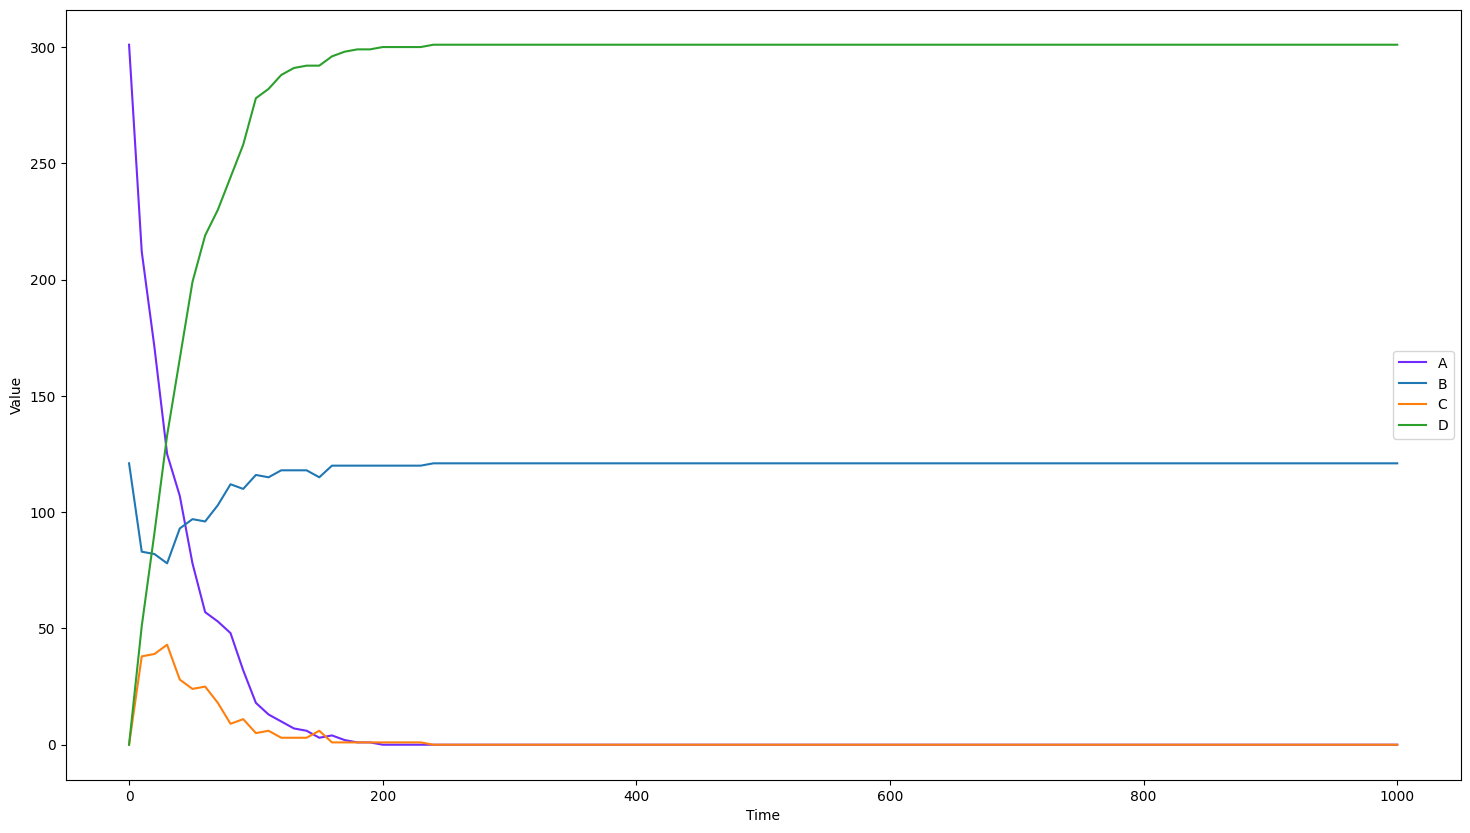

In [3]:
myModel = MichaelisMenten()

myServer = ComputeServer("localhost", port=1234)

results = RemoteSimulation.on(myServer).with_model(myModel).run()

results = results.resolve()

results.plot()

While the model.run() function can be called without any given arguments, GillesPy2 provides several options for customizing your simulations. The following keyword arguments can be used in the model.run() function to customize your simulations:
<br/><br/>
### model.run() kwargs
**solver=[solver]**  
    manually choose a solver/algorithm one of the following GillesPy2 solvers:  
    [ODESolver()](./StartingModels/Michaelis-Menten_Basic_ODE.ipynb)  
    [SSASolver()](./StartingModels/Michaelis-Menten_NumPy_SSA.ipynb)    
    [SSACSolver()](./StartingModels/Michaelis-Menten_SSA_C.ipynb)    
    [TauLeapingSolver()](./StartingModels/Michaelis-Menten_Basic_Tau_Leaping.ipynb)    
    [TauHybridSolver()](./StartingModels/Michaelis-Menten_Basic_Tau_Hybrid.ipynb)    
    
**number_of_trajectories=1**  
    [int]: Number of times to run the current simulation  
    
**seed=None**  
    [int]: Define a custom seed for random number generation

**show_labels=True**  
    [bool]: When set to true (default) returns results in a dictonary with time and species as dictionary keys, and relevant trajectory vectors as value pair.  When set to False, results will be returned as a numpy array with dimensions [timestep][species_index].  Either way, the the results of each trajectory are stored in a list.

<br/><br/>
### results.plot() kwargs
***xaxis_label='Time (s)'***  
    [string]: Label for the plot's x-axis  
***yaxis_label='Species Population'***  
    [string]: Label for the plot's y-axis  
***style='default'***  
    [string]: matplotlib stylesheets https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html  
***title=None***  
    [string]: title of figure  
***show_legend=True***  
    [bool]: Show legend if true.  
***multiple_graphs=False***  
    [bool]: if each trajectory should have its own graph or if they should overlap  
***included_species_list=[]***  
    [list]: A list of strings describing which species to include by species name. By default displays all species.  
    
<br/><br/>
GillesPy2 also offers built-in offline plotly plotting and statistical data plotting.  [See the documents for more details.](https://gillespy2.readthedocs.io)  
<br/><br/>
  
### Solver specific kwargs
**ODESolver, TauHybridSolver: integrator='lsoda'**  
    [String]:  
integrator to be used form scipy.integrate.ode. Options include 'vode', 'zvode', 'lsoda', 'dopri5', and 'dop835'.  For more details, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html  
  
**ODESolver, TauHybridSolver: integrator_options={}**  
    [dictionary]:  
contains options to the scipy integrator. for a list of options, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html  
  
**TauLeapingSolver, TauHybridSolver: tau_tol=0.03**  
    [float]:  
Relative error tolerance value for calculating tau_step. value should be between 0.0-1.0  
  
**TauHybridSolver: switch_tol=0.03**  
    [float]:  
Relative error tolerance value for switching between deterministic/stochastic.  value should be between 0.0-1.0 
<br/><br/>

## HYBRID - ADVANCED

Some of the solvers in GillesPy2 provide further options for customizing simulations.  For examples on how to use these advanced features, please see the following links:  

[Hybrid: Using Rate Rules to model continuous species](./AdvancedExamples/Hybrid/hybrid_continuous_species.ipynb)  
[Hybrid: Dynamically switching between stochastic and deterministic representations](./AdvancedExamples/Hybrid/hybrid_switching_example.ipynb)  


